# Creating the boundary forcing

In [1]:
from roms_tools import Grid, BoundaryForcing



As always, the first step is to create our grid. Note that it is important to use the same grid throughout all the steps (i.e., creating tidal forcing, surface forcing, initial conditions, etc.) to set up a consistent ROMS simulation. Here we use the following grid.

In [2]:
grid = Grid(
    nx=100, ny=100, size_x=1800, size_y=2400, center_lon=-21, center_lat=61, rot=20
)

Next, we specify the temporal range that we want to make the surface forcing for.

In [3]:
from datetime import datetime

In [4]:
start_time = datetime(2012, 1, 2)
end_time = datetime(2012, 1, 4)

`ROMS-Tools` can create two types of boundary forcing:

* physical boundary forcing like temperature, salinity, velocities, and sea surface height
* biogeochemical (BGC) boundary forcing like alkalinity, dissolved inorganic phosphate, etc.

As with surface forcing, ROMS accepts multiple boundary forcing files, so we create these two types separately.

## Physical boundary forcing

In this section, we use GLORYS data to create our physical boundary forcing. The user is expected to have downloaded the GLORYS data spanning the desired ROMS domain and temporal range. You can download the GLORYS data from https://www.mercator-ocean.eu/en/ocean-science/glorys/. Our downloaded data sits at the following location.

In [5]:
path = [
    "/global/cfs/projectdirs/m4746/Datasets/GLORYS/NA/2012/mercatorglorys12v1_gl12_mean_20120101.nc",  # include data from day before start time, just to be save
    "/global/cfs/projectdirs/m4746/Datasets/GLORYS/NA/2012/mercatorglorys12v1_gl12_mean_20120102.nc",
    "/global/cfs/projectdirs/m4746/Datasets/GLORYS/NA/2012/mercatorglorys12v1_gl12_mean_20120103.nc",
    "/global/cfs/projectdirs/m4746/Datasets/GLORYS/NA/2012/mercatorglorys12v1_gl12_mean_20120104.nc",
    "/global/cfs/projectdirs/m4746/Datasets/GLORYS/NA/2012/mercatorglorys12v1_gl12_mean_20120105.nc",  # include data from day after end time, just to be save
]

Note that we could have also specified the data location via a wildcard, e.g., `path='/glade/derecho/scratch/bachman/GLORYS/NA/2012/*.nc'`. But with this latter choice, `ROMS-Tools` will operate quite a bit slower. More specific filenames are better!

We now create an instance of the `BoundaryForcing` class with `type = "physics"`.

In [6]:
%%time

boundary_forcing = BoundaryForcing(
    grid=grid,
    start_time=start_time,
    end_time=end_time,
    source={"name": "GLORYS", "path": path},
    type="physics",  # "physics" or "bgc"; default is "physics"
    use_dask=True,  # default is False
)

CPU times: user 1min 7s, sys: 266 ms, total: 1min 7s
Wall time: 6.89 s


The boundary forcing variables are held in an `xarray.Dataset` that is accessible via the `.ds` property.

In [7]:
boundary_forcing.ds

<xarray.Dataset> Size: 3MB
Dimensions:     (bry_time: 4, xi_rho: 102, s_rho: 100, xi_u: 101, eta_rho: 102,
                 eta_v: 101)
Coordinates:
    abs_time    (bry_time) datetime64[ns] 32B 2012-01-01T12:00:00 ... 2012-01...
  * bry_time    (bry_time) float64 32B 4.384e+03 4.384e+03 4.386e+03 4.386e+03
Dimensions without coordinates: xi_rho, s_rho, xi_u, eta_rho, eta_v
Data variables: (12/28)
    zeta_south  (bry_time, xi_rho) float32 2kB dask.array<chunksize=(1, 102), meta=np.ndarray>
    temp_south  (bry_time, s_rho, xi_rho) float32 163kB dask.array<chunksize=(1, 100, 102), meta=np.ndarray>
    salt_south  (bry_time, s_rho, xi_rho) float32 163kB dask.array<chunksize=(1, 100, 102), meta=np.ndarray>
    u_south     (bry_time, s_rho, xi_u) float32 162kB dask.array<chunksize=(1, 100, 101), meta=np.ndarray>
    v_south     (bry_time, s_rho, xi_rho) float32 163kB dask.array<chunksize=(1, 100, 102), meta=np.ndarray>
    ubar_south  (bry_time, xi_u) float32 2kB dask.array<chunksize=(1, 101), meta=np.ndarray>
    ...          ...
    temp_west   (bry_time, s_rho, eta_rho) float32 163kB dask.array<chunksize=(1, 100, 102), meta=np.ndarray>
    salt_west   (bry_time, s_rho, eta_rho) float32 163kB dask.array<chunksize=(1, 100, 102), meta=np.ndarray>
    u_west      (bry_time, s_rho, eta_rho) float32 163kB dask.array<chunksize=(1, 100, 102), meta=np.ndarray>
    v_west      (bry_time, s_rho, eta_v) float32 162kB dask.array<chunksize=(1, 100, 101), meta=np.ndarray>
    ubar_west   (bry_time, eta_rho) float32 2kB dask.array<chunksize=(1, 102), meta=np.ndarray>
    vbar_west   (bry_time, eta_v) float32 2kB dask.array<chunksize=(1, 101), meta=np.ndarray>
Attributes:
    title:                 ROMS boundary forcing file created by ROMS-Tools
    roms_tools_version:    0.1.dev138+dirty
    start_time:            2012-01-02 00:00:00
    end_time:              2012-01-04 00:00:00
    source:                GLORYS
    model_reference_date:  2000-01-01 00:00:00
    theta_s:               5.0
    theta_b:               2.0
    hc:                    300.0

All physical boundary forcing fields necessary to run a ROMS simulation are now contained as `dask.arrays` within an `xarray.Dataset`. All data operations are performed lazily, meaning that the surface forcing fields have not been actually computed yet. Full computation will not be triggered until the `.save` method is called.

In [8]:
boundary_forcing.ds.bry_time

<xarray.DataArray 'bry_time' (bry_time: 4)> Size: 32B
array([4383.5, 4384.5, 4385.5, 4386.5])
Coordinates:
    abs_time  (bry_time) datetime64[ns] 32B 2012-01-01T12:00:00 ... 2012-01-0...
  * bry_time  (bry_time) float64 32B 4.384e+03 4.384e+03 4.386e+03 4.386e+03
Attributes:
    long_name:  days since 2000-01-01 00:00:00
    units:      days

The `bry_time` variable shows relative time, i.e., days since the model reference date (here set to January 1, 2000 by default). The `abs_time` coordinate shows the absolute time. The GLORYS data provided to `ROMS-Tools` has daily frequency; this temporal frequency is inherited by `boundary_forcing`. 

`boundary_forcing` has 4 time entries because `ROMS-Tools` makes sure to include one time entry at or before the `start_time`, and one time entry at or after the `end_time`. This is essential for proper functioning within ROMS. If the provided data does not meet this requirement, `ROMS-Tools` will issue a warning.

Let's make some plots! As an example, let's have a look at the zonal velocity field `u` at the southern and western boundaries.

In [9]:
from dask.diagnostics import ProgressBar

[########################################] | 100% Completed | 76.93 ss
CPU times: user 2h 43min 6s, sys: 1.1 s, total: 2h 43min 7s
Wall time: 1min 17s


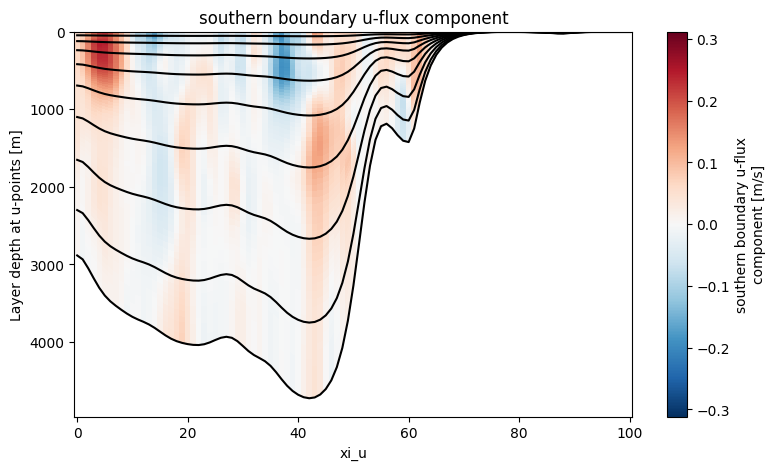

In [10]:
with ProgressBar():
    %time boundary_forcing.plot("u_south", time=0, layer_contours=True)

[########################################] | 100% Completed | 79.21 ss
CPU times: user 2h 47min 57s, sys: 872 ms, total: 2h 47min 58s
Wall time: 1min 19s


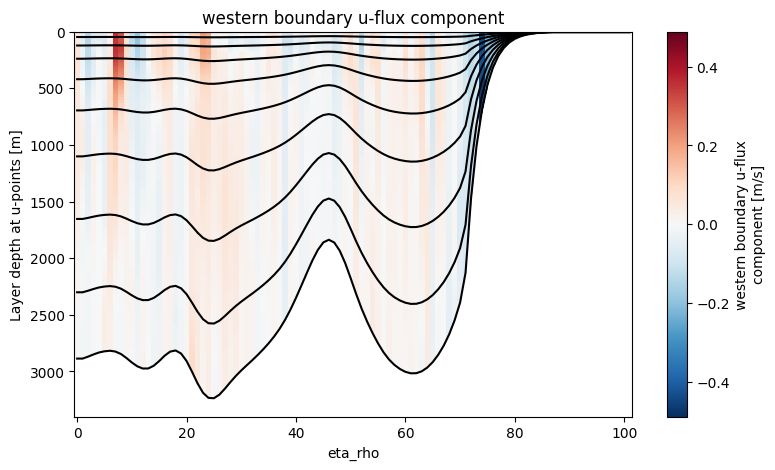

In [11]:
with ProgressBar():
    %time boundary_forcing.plot("u_west", time=0, layer_contours=True)

Sea surface height `zeta` at any of the boundaries and for a specific time is only a 1D variable.

[########################################] | 100% Completed | 101.78 ms
CPU times: user 14.1 s, sys: 0 ns, total: 14.1 s
Wall time: 146 ms


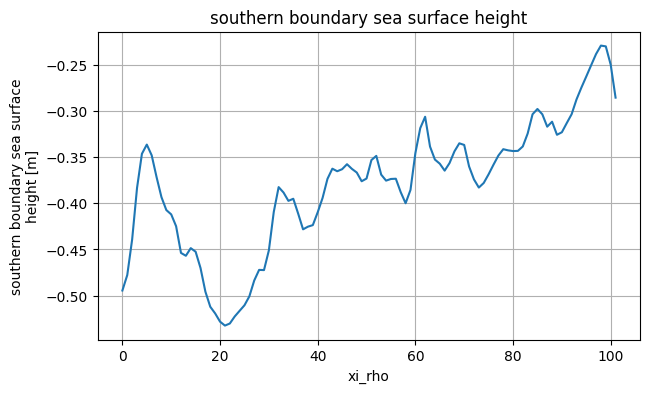

In [12]:
with ProgressBar():
    %time boundary_forcing.plot("zeta_south", time=0)

The same is true for the barotropic velocity `ubar`.

[########################################] | 100% Completed | 78.37 ss
CPU times: user 2h 46min 41s, sys: 1.01 s, total: 2h 46min 42s
Wall time: 1min 18s


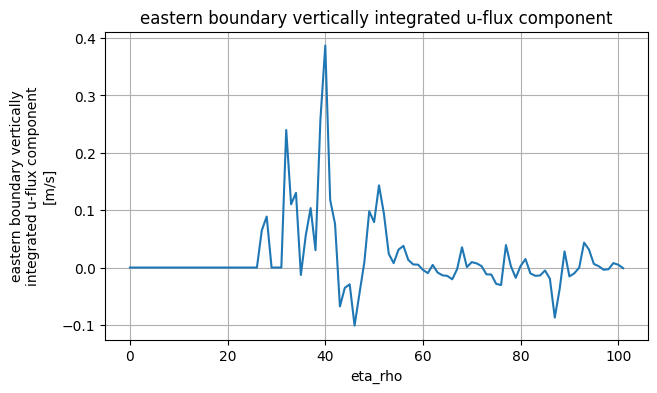

In [13]:
with ProgressBar():
    %time boundary_forcing.plot("ubar_east", time=0)

## Biogeochemical (BGC) boundary forcing
We now create BGC boundary forcing. The BGC variables are interpolated from a CESM climatology, which is located here.

In [15]:
path = "/global/cfs/projectdirs/m4746/Datasets/CESM_REGRIDDED/CESM-climatology_lowres_regridded.nc"

In [16]:
%%time

bgc_boundary_forcing = BoundaryForcing(
    grid=grid,
    start_time=start_time,
    end_time=end_time,
    source={"name": "CESM_REGRIDDED", "path": path, "climatology": True},
    type="bgc",
    use_dask=True,
)

CPU times: user 4.28 s, sys: 56 ms, total: 4.34 s
Wall time: 5.13 s


In [17]:
bgc_boundary_forcing.ds

<xarray.Dataset> Size: 63MB
Dimensions:            (bry_time: 12, s_rho: 100, xi_rho: 102, eta_rho: 102)
Coordinates:
    abs_time           (bry_time) datetime64[ns] 96B 2000-01-16 ... 2000-12-15
  * bry_time           (bry_time) float64 96B 15.0 45.0 74.0 ... 319.0 349.0
Dimensions without coordinates: s_rho, xi_rho, eta_rho
Data variables: (12/128)
    PO4_south          (bry_time, s_rho, xi_rho) float32 490kB dask.array<chunksize=(12, 100, 102), meta=np.ndarray>
    NO3_south          (bry_time, s_rho, xi_rho) float32 490kB dask.array<chunksize=(12, 100, 102), meta=np.ndarray>
    SiO3_south         (bry_time, s_rho, xi_rho) float32 490kB dask.array<chunksize=(12, 100, 102), meta=np.ndarray>
    NH4_south          (bry_time, s_rho, xi_rho) float32 490kB dask.array<chunksize=(12, 100, 102), meta=np.ndarray>
    Fe_south           (bry_time, s_rho, xi_rho) float32 490kB dask.array<chunksize=(12, 100, 102), meta=np.ndarray>
    Lig_south          (bry_time, s_rho, xi_rho) float32 490kB dask.array<chunksize=(12, 100, 102), meta=np.ndarray>
    ...                 ...
    diazChl_west       (bry_time, s_rho, eta_rho) float32 490kB dask.array<chunksize=(12, 100, 102), meta=np.ndarray>
    diazC_west         (bry_time, s_rho, eta_rho) float32 490kB dask.array<chunksize=(12, 100, 102), meta=np.ndarray>
    diazP_west         (bry_time, s_rho, eta_rho) float32 490kB dask.array<chunksize=(12, 100, 102), meta=np.ndarray>
    diazFe_west        (bry_time, s_rho, eta_rho) float32 490kB dask.array<chunksize=(12, 100, 102), meta=np.ndarray>
    spCaCO3_west       (bry_time, s_rho, eta_rho) float32 490kB dask.array<chunksize=(12, 100, 102), meta=np.ndarray>
    zooC_west          (bry_time, s_rho, eta_rho) float32 490kB dask.array<chunksize=(12, 100, 102), meta=np.ndarray>
Attributes:
    title:                 ROMS boundary forcing file created by ROMS-Tools
    roms_tools_version:    0.1.dev138+dirty
    start_time:            2012-01-02 00:00:00
    end_time:              2012-01-04 00:00:00
    source:                CESM_REGRIDDED
    model_reference_date:  2000-01-01 00:00:00
    theta_s:               5.0
    theta_b:               2.0
    hc:                    300.0
    climatology:           True

In [18]:
bgc_boundary_forcing.ds["bry_time"]

<xarray.DataArray 'bry_time' (bry_time: 12)> Size: 96B
array([ 15.,  45.,  74., 105., 135., 166., 196., 227., 258., 288., 319., 349.])
Coordinates:
    abs_time  (bry_time) datetime64[ns] 96B 2000-01-16 2000-02-15 ... 2000-12-15
  * bry_time  (bry_time) float64 96B 15.0 45.0 74.0 105.0 ... 288.0 319.0 349.0
Attributes:
    long_name:     days since 2000-01-01 00:00:00
    units:         days
    cycle_length:  365.25

Note that `bgc_boundary_forcing.ds` has twelve time entries because the data in `source = {"name": "CESM_REGRIDDED", "path": bgc_path, "climatology": True}` is a climatology. 

For climatologies, `ROMS-Tools` does not subsample the twelve time entries further, regardless of the provided start and end time. Note that the `bry_time` coordinate has an additional attribute: `cycle_length` (with units in days). This attribute will tell ROMS to repeat the climatology every 365.25 days. In other words, the data in `bgc_boundary_forcing.ds` will work for ROMS run over any time window (as long as the model reference date is January 1, xxxx).

We can plot the BGC boundary forcing as we saw above.

[########################################] | 100% Completed | 1.61 sms
CPU times: user 727 ms, sys: 192 ms, total: 919 ms
Wall time: 1.68 s


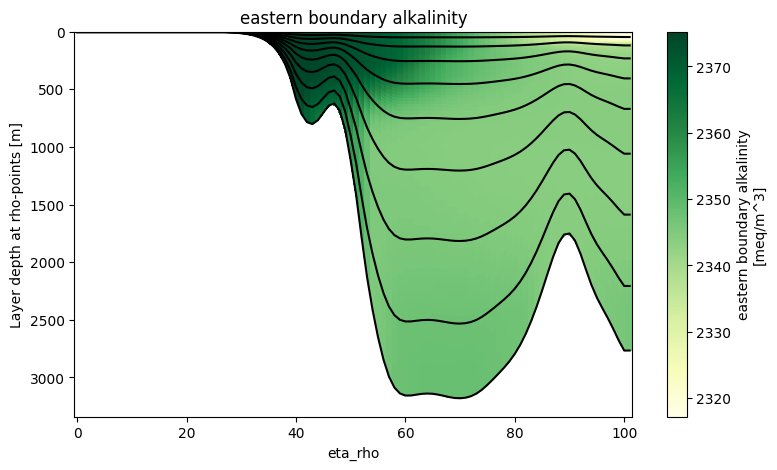

In [19]:
with ProgressBar():
    %time bgc_boundary_forcing.plot("ALK_east", time=0, layer_contours=True)

## Saving as NetCDF or YAML file
We can now save our boundary forcing as a NetCDF file. We need to specify a prefix for the desired target path.

In [20]:
filepath = "/pscratch/sd/n/nloose/forcing/my_boundary_forcing"

`ROMS-Tools` will group the boundary forcing by year and month and append the year and month information to this path. The files will be named with the format `filepath.YYYYMM.nc` if a full month of data is included (at least one data point per day), or `filepath.YYYYMMDD-DD.nc` otherwise.

In [21]:
with ProgressBar():
    %time boundary_forcing.save(filepath)

[########################################] | 100% Completed | 370.73 s
CPU times: user 13h 11min 47s, sys: 13.6 s, total: 13h 12min 1s
Wall time: 6min 10s


We can also export the parameters of our `BoundaryForcing` object to a YAML file.

In [22]:
yaml_filepath = "/pscratch/sd/n/nloose/forcing/my_boundary_forcing.yaml"

In [23]:
boundary_forcing.to_yaml(yaml_filepath)

This is the YAML file that was created.

In [24]:
# Open and read the YAML file
with open(yaml_filepath, "r") as file:
    file_contents = file.read()

# Print the contents
print(file_contents)

---
roms_tools_version: 0.1.dev138+dirty
---
BoundaryForcing:
  boundaries:
    east: true
    north: true
    south: true
    west: true
  end_time: '2012-01-04T00:00:00'
  model_reference_date: '2000-01-01T00:00:00'
  source:
    climatology: false
    name: GLORYS
    path:
    - /global/cfs/projectdirs/m4746/Datasets/GLORYS/NA/2012/mercatorglorys12v1_gl12_mean_20120101.nc
    - /global/cfs/projectdirs/m4746/Datasets/GLORYS/NA/2012/mercatorglorys12v1_gl12_mean_20120102.nc
    - /global/cfs/projectdirs/m4746/Datasets/GLORYS/NA/2012/mercatorglorys12v1_gl12_mean_20120103.nc
    - /global/cfs/projectdirs/m4746/Datasets/GLORYS/NA/2012/mercatorglorys12v1_gl12_mean_20120104.nc
    - /global/cfs/projectdirs/m4746/Datasets/GLORYS/NA/2012/mercatorglorys12v1_gl12_mean_20120105.nc
  start_time: '2012-01-02T00:00:00'
  type: physics
Grid:
  N: 100
  center_lat: 61
  center_lon: -21
  hc: 300.0
  hmin: 5.0
  nx: 100
  ny: 100
  rot: 20
  size_x: 1800
  size_y: 2400
  theta_b: 2.0
  theta_s: 5.0
 

## Creating boundary forcing from an existing YAML file

In [25]:
%time the_same_boundary_forcing = BoundaryForcing.from_yaml(yaml_filepath, use_dask=True)

CPU times: user 2min 9s, sys: 384 ms, total: 2min 9s
Wall time: 6.79 s


In [26]:
the_same_boundary_forcing.ds

<xarray.Dataset> Size: 3MB
Dimensions:     (bry_time: 4, xi_rho: 102, s_rho: 100, xi_u: 101, eta_rho: 102,
                 eta_v: 101)
Coordinates:
    abs_time    (bry_time) datetime64[ns] 32B 2012-01-01T12:00:00 ... 2012-01...
  * bry_time    (bry_time) float64 32B 4.384e+03 4.384e+03 4.386e+03 4.386e+03
Dimensions without coordinates: xi_rho, s_rho, xi_u, eta_rho, eta_v
Data variables: (12/28)
    zeta_south  (bry_time, xi_rho) float32 2kB dask.array<chunksize=(1, 102), meta=np.ndarray>
    temp_south  (bry_time, s_rho, xi_rho) float32 163kB dask.array<chunksize=(1, 100, 102), meta=np.ndarray>
    salt_south  (bry_time, s_rho, xi_rho) float32 163kB dask.array<chunksize=(1, 100, 102), meta=np.ndarray>
    u_south     (bry_time, s_rho, xi_u) float32 162kB dask.array<chunksize=(1, 100, 101), meta=np.ndarray>
    v_south     (bry_time, s_rho, xi_rho) float32 163kB dask.array<chunksize=(1, 100, 102), meta=np.ndarray>
    ubar_south  (bry_time, xi_u) float32 2kB dask.array<chunksize=(1, 101), meta=np.ndarray>
    ...          ...
    temp_west   (bry_time, s_rho, eta_rho) float32 163kB dask.array<chunksize=(1, 100, 102), meta=np.ndarray>
    salt_west   (bry_time, s_rho, eta_rho) float32 163kB dask.array<chunksize=(1, 100, 102), meta=np.ndarray>
    u_west      (bry_time, s_rho, eta_rho) float32 163kB dask.array<chunksize=(1, 100, 102), meta=np.ndarray>
    v_west      (bry_time, s_rho, eta_v) float32 162kB dask.array<chunksize=(1, 100, 101), meta=np.ndarray>
    ubar_west   (bry_time, eta_rho) float32 2kB dask.array<chunksize=(1, 102), meta=np.ndarray>
    vbar_west   (bry_time, eta_v) float32 2kB dask.array<chunksize=(1, 101), meta=np.ndarray>
Attributes:
    title:                 ROMS boundary forcing file created by ROMS-Tools
    roms_tools_version:    0.1.dev138+dirty
    start_time:            2012-01-02 00:00:00
    end_time:              2012-01-04 00:00:00
    source:                GLORYS
    model_reference_date:  2000-01-01 00:00:00
    theta_s:               5.0
    theta_b:               2.0
    hc:                    300.0